# Importing Neccessary Libraries


In [1]:
import pandas as pd 
import requests 
import numpy as np 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json 
import matplotlib as mpl
import matplotlib.pyplot as plt
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim 
from pandas.io.json import json_normalize 
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
!conda install -c conda-forge folium=0.5.0 --yes 
import folium 
!pip install lxml
import lxml

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    ca-certificates-2019.9.11  |       hecc5488_0         144 KB  conda-forge
    certifi-2019.9.11          |           py36_0         147 KB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

# New York Raw Data

In [2]:
# Downloading  New York Data

!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
    
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    
neighborhoods_data = newyork_data['features']

column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
neighborhoods = pd.DataFrame(columns=column_names)

# Keeping only  useful data

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
Downtown_NY = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
Downtown_NY.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


# Toronto Data

In [3]:
# Scraping Wikipedia Table
TorontoRD=pd.read_html("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")[0] 
# Replacing with non-assigned values
TorontoRD['Borough'] = TorontoRD['Borough'].replace('Not assigned', np.nan)
TorontoRD = TorontoRD.dropna(axis=0, subset=['Borough']) 
TorontoRD['Neighbourhood'] = TorontoRD['Neighbourhood'].replace('Not assigned', np.nan)
TorontoRD.Neighbourhood.fillna(TorontoRD.Borough,inplace=True) 
TorontoRD = TorontoRD.groupby(by=['Postcode','Borough'],sort = False).agg(lambda x: ','.join(x))
TorontoRD=TorontoRD.reset_index() 
Toronto_df=TorontoRD 
# Reading CSV file for Toronto coordinates
path='http://cocl.us/Geospatial_data'
Toronto_new=pd.read_csv(path)
# Merging the two dataset
Toronto_df=Toronto_df.sort_values(by=['Postcode'], axis=0)
Toronto_df.reset_index(inplace=True)
Toronto_df.drop('index', inplace=True, axis=1)
Toronto_df[['Latitude','Longitude']]=Toronto_new[['Latitude','Longitude']]
Downtown_Toronto = Toronto_df[Toronto_df['Borough'] == 'Downtown Toronto'].reset_index(drop=True)
Downtown_Toronto.drop('Postcode', inplace=True, axis=1)
Downtown_Toronto=Downtown_Toronto.rename(columns={'Neighbourhood': 'Neighborhood'})
Downtown_Toronto.head()

,Borough,Neighborhood,Latitude,Longitude
0,Downtown Toronto,Rosedale,43.679563,-79.377529
1,Downtown Toronto,"Cabbagetown,St. James Town",43.667967,-79.367675
2,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
3,Downtown Toronto,"Harbourfront,Regent Park",43.654260,-79.360636
4,Downtown Toronto,"Ryerson,Garden District",43.657162,-79.378937


# Exploring Downtown Neighbourhoods in Both Cities  Using  Foursquare credentials

### Passing Foursquare Credentials

In [4]:
#  100 venues in 500 m radius of location
CLIENT_ID = '40QYIXJHZ1SS0ISI3HBHDECMGEHIGN0VMKQUH4YKFN0UCLYE' 
CLIENT_SECRET ='C30ZV1NMM4YFE5Q4WUMPYRPW0DB23EHI1HY2LDFBUJ5ZQKWV' 
VERSION = '20180605' 
LIMIT = 100 
radius = 500 

In [5]:
# Defining a function to get all the venues in the neighbourhood

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['id'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue',
                  'Venue ID', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Getting Downtown New York and Downtown Toronto Neighbourhood Venues

In [6]:
NY_venues = getNearbyVenues(names=Downtown_NY['Neighborhood'],
                                   latitudes=Downtown_NY['Latitude'],
                                   longitudes=Downtown_NY['Longitude']
                                  )

In [9]:
Toronto_venues = getNearbyVenues(names=Downtown_Toronto['Neighborhood'],
                                   latitudes=Downtown_Toronto['Latitude'],
                                   longitudes=Downtown_Toronto['Longitude']
                                  )

#### Dropping the duplicates of venues at the corner of different neighbourhoods

In [7]:
NY_venues = NY_venues.drop_duplicates(subset='Venue ID', keep='first', inplace=False)
NY_venues=NY_venues.reset_index(drop=True) 

In [10]:
Toronto_venues = Toronto_venues.drop_duplicates(subset='Venue ID', keep='first', inplace=False)
Toronto_venues= Toronto_venues.reset_index(drop=True) 

# Examining Specific Dietary Options in New York and Toronto

The dietary options are:

* Gluten-Free
* Fast Food
* Halal
* Kosher
* Salad 
* Sandwich
* Seafood
* Soup
* Vegetarian / Vegan 

In [11]:
NY_GlutenFree=NY_venues[NY_venues['Venue Category']=='Gluten-free Restaurant'].reset_index(drop=True)
Toronto_GlutenFree=Toronto_venues[Toronto_venues['Venue Category']=='Gluten-free Restaurant'].reset_index(drop=True)
NY_Halal=NY_venues[NY_venues['Venue Category']=='Halal Restaurant'].reset_index(drop=True)
Toronto_Halal=Toronto_venues[Toronto_venues['Venue Category']=='Halal Restaurant'].reset_index(drop=True)
NY_Kosher=NY_venues[NY_venues['Venue Category']=='Kosher Restaurant'].reset_index(drop=True)
Toronto_Kosher=Toronto_venues[Toronto_venues['Venue Category']=='Kosher Restaurant'].reset_index(drop=True)
NY_FastFood=NY_venues[NY_venues['Venue Category']=='Fast Food Restaurant'].reset_index(drop=True)
Toronto_FastFood=Toronto_venues[Toronto_venues['Venue Category']=='Fast Food Restaurant'].reset_index(drop=True)
NY_Salad=NY_venues[NY_venues['Venue Category']=='Salad Place'].reset_index(drop=True)
Toronto_Salad=Toronto_venues[Toronto_venues['Venue Category']=='Salad Place'].reset_index(drop=True)
NY_Sandwich=NY_venues[NY_venues['Venue Category']=='Sandwich Place'].reset_index(drop=True)
Toronto_Sandwich=Toronto_venues[Toronto_venues['Venue Category']=='Sandwich Place'].reset_index(drop=True)
NY_SeaFood=NY_venues[NY_venues['Venue Category']=='Seafood Restaurant'].reset_index(drop=True)
Toronto_SeaFood=Toronto_venues[Toronto_venues['Venue Category']=='Seafood Restaurant'].reset_index(drop=True)
NY_Soup=NY_venues[NY_venues['Venue Category']=='Soup Place'].reset_index(drop=True)
Toronto_Soup=Toronto_venues[Toronto_venues['Venue Category']=='Soup Place'].reset_index(drop=True)
NY_VegiVegan=NY_venues[NY_venues['Venue Category']=='Vegetarian / Vegan Restaurant'].reset_index(drop=True)
Toronto_VegiVegan=Toronto_venues[Toronto_venues['Venue Category']=='Vegetarian / Vegan Restaurant'].reset_index(drop=True)

# Examining Ethnic foods in New York and Toronto
 
 The following ethnic cuisines are examined in this report:
 
 * Brazilian
 * Chinese 
 * Colombian 
 * Ethiopian
 * French
 * Greek
 * Indian 
 * Italian
 * Japanese 
 * Lebanese 
 * Mexican
 * Persian 
 * Turkish

In [15]:
NY_Chinese=NY_venues[NY_venues['Venue Category']=='Chinese Restaurant'].reset_index(drop=True)
Toronto_Chinese=Toronto_venues[Toronto_venues['Venue Category']=='Chinese Restaurant'].reset_index(drop=True)
NY_Japanese=NY_venues[NY_venues['Venue Category']=='Japanese Restaurant'].reset_index(drop=True)
Toronto_Japanese=Toronto_venues[Toronto_venues['Venue Category']=='Japanese Restaurant'].reset_index(drop=True)
NY_Indian=NY_venues[NY_venues['Venue Category']=='Indian Restaurant'].reset_index(drop=True)
Toronto_Indian=Toronto_venues[Toronto_venues['Venue Category']=='Indian Restaurant'].reset_index(drop=True)
NY_French=NY_venues[NY_venues['Venue Category']=='French Restaurant'].reset_index(drop=True)
Toronto_French=Toronto_venues[Toronto_venues['Venue Category']=='French Restaurant'].reset_index(drop=True)
NY_Greek=NY_venues[NY_venues['Venue Category']=='Greek Restaurant'].reset_index(drop=True)
Toronto_Greek=Toronto_venues[Toronto_venues['Venue Category']=='Greek Restaurant'].reset_index(drop=True)
NY_Italian=NY_venues[NY_venues['Venue Category']=='Italian Restaurant'].reset_index(drop=True)
Toronto_Italian=Toronto_venues[Toronto_venues['Venue Category']=='Italian Restaurant'].reset_index(drop=True)
NY_Lebanese=NY_venues[NY_venues['Venue Category']=='Lebanese Restaurant'].reset_index(drop=True)
Toronto_Lebanese=Toronto_venues[Toronto_venues['Venue Category']=='Lebanese Restaurant'].reset_index(drop=True)
NY_Persian=NY_venues[NY_venues['Venue Category']=='Persian Restaurant'].reset_index(drop=True)
Toronto_Persian=Toronto_venues[Toronto_venues['Venue Category']=='Persian Restaurant'].reset_index(drop=True)
NY_Turkish=NY_venues[NY_venues['Venue Category']=='Turkish Restaurant'].reset_index(drop=True)
Toronto_Turkish=Toronto_venues[Toronto_venues['Venue Category']=='Turkish Restaurant'].reset_index(drop=True)
NY_Mexican=NY_venues[NY_venues['Venue Category']=='Mexican Restaurant'].reset_index(drop=True)
Toronto_Mexican=Toronto_venues[Toronto_venues['Venue Category']=='Mexican Restaurant'].reset_index(drop=True)
NY_Brazilian=NY_venues[NY_venues['Venue Category']=='Brazilian Restaurant'].reset_index(drop=True)
Toronto_Brazilian=Toronto_venues[Toronto_venues['Venue Category']=='Brazilian Restaurant'].reset_index(drop=True)
NY_Colombian=NY_venues[NY_venues['Venue Category']=='Colombian Restaurant'].reset_index(drop=True)
Toronto_Colombian=Toronto_venues[Toronto_venues['Venue Category']=='Colombian Restaurant'].reset_index(drop=True)
NY_Ethiopian=NY_venues[NY_venues['Venue Category']=='Ethiopian Restaurant'].reset_index(drop=True)
Toronto_Ethiopian=Toronto_venues[Toronto_venues['Venue Category']=='Ethiopian Restaurant'].reset_index(drop=True)

### Creating  Dietary Option Table

In [16]:
Dietary={'Name':['Gluten-Free','Fast Food','Halal','Kosher','Salad Place','Sandwich Place','Seafood','Soup Place','Vegetarian / Vegan '],
         'New York':[len(NY_GlutenFree),len(NY_FastFood),len(NY_Halal),len(NY_Kosher),len(NY_Salad),len(NY_Sandwich),len(NY_SeaFood),len(NY_Soup),len(NY_VegiVegan)],
         'Toronto':[len(Toronto_GlutenFree),len(Toronto_FastFood),len(Toronto_Halal),len(Toronto_Kosher),len(Toronto_Salad),\
                    len(Toronto_Sandwich),len(Toronto_SeaFood),len(Toronto_Soup),len(Toronto_VegiVegan)]}

In [17]:
df = pd.DataFrame(Dietary) 

In [18]:
df.set_index('Name', inplace=True)

In [19]:
df.head(10)

,New York,Toronto
Name,,
Gluten-Free,0,1
Fast Food,4,7
Halal,0,0
Kosher,1,0
Salad Place,16,4
Sandwich Place,47,11
Seafood,34,8
Soup Place,2,0
Vegetarian / Vegan,21,12


### Plotting Results

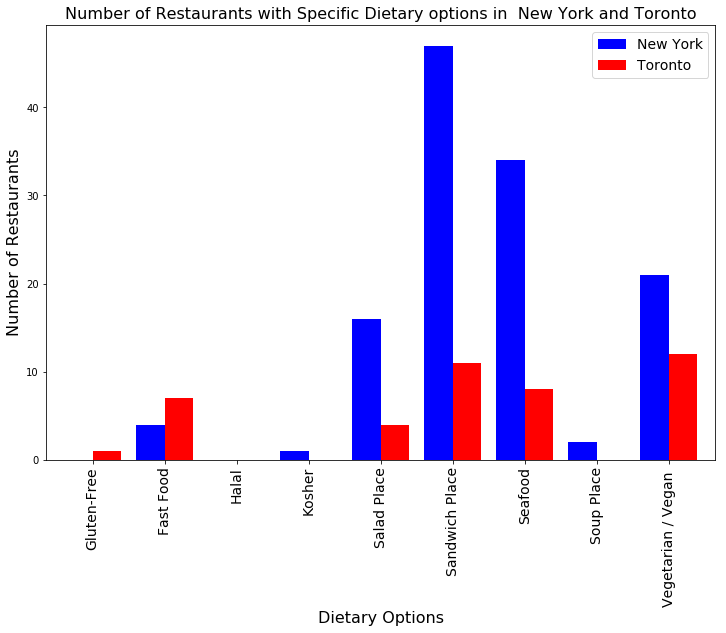

In [22]:
ax=df[['New York', 'Toronto']].plot(kind='bar', figsize=(12,8), width=0.8, color=['b','r'])
legend=ax.legend(prop={'size':14})
ax.set_title("Number of Restaurants with Specific Dietary options in  New York and Toronto", Fontsize=16)
ax.set_xlabel("Dietary Options", Fontsize=16)
ax.set_ylabel("Number of Restaurants", Fontsize=16)
ax.tick_params(axis='x',labelsize=14)
plt.show()

## Getting Restaurant Rates

In [25]:
NY_FastFood['Rating']=np.nan
Toronto_FastFood['Rating']=np.nan
NY_VegiVegan['Rating']=np.nan
Toronto_VegiVegan['Rating']=np.nan

### Defining a new function to get the all ratings

In [26]:
def Ratings(VenueName):
    for i in range(0,len(VenueName)):
        venue_id=VenueName['Venue ID'].iloc[i]
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
        result = requests.get(url).json()
        try:
            VenueName['Rating'].iloc[i]=result['response']['venue']['rating']
        except:
              print('This venue has not been rated yet.')
                
    return(VenueName)  

In [27]:
Ratings(NY_FastFood)
Ratings(Toronto_FastFood)
Ratings(NY_VegiVegan)
Ratings(Toronto_VegiVegan)

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category,Rating
0,"Ryerson,Garden District",43.657162,-79.378937,Urban Herbivore,4e5ff713ae60e9edf4ac0172,43.654972,-79.380856,Vegetarian / Vegan Restaurant,8.0
1,St. James Town,43.651494,-79.375418,Fresh On Front,5b5bca904aa3f8002c97f85d,43.647815,-79.374453,Vegetarian / Vegan Restaurant,8.5
2,Central Bay Street,43.657952,-79.387383,Vegetarian Haven,4aeb711ef964a52017c221e3,43.656016,-79.392758,Vegetarian / Vegan Restaurant,8.5
3,"Adelaide,King,Richmond",43.650571,-79.384568,Rosalinda,5aff06ca6e4650002cc6286b,43.650252,-79.385156,Vegetarian / Vegan Restaurant,8.6
4,"Adelaide,King,Richmond",43.650571,-79.384568,Planta Queen,5c9d602f25fb7b002c79b669,43.650622,-79.388154,Vegetarian / Vegan Restaurant,7.7
5,"Harbourfront East,Toronto Islands,Union Station",43.640816,-79.381752,Kupfert & Kim,5481b06c498ee191fa045a00,43.641179,-79.378144,Vegetarian / Vegan Restaurant,7.3
6,"Chinatown,Grange Park,Kensington Market",43.653206,-79.400049,Cosmic Treats,55ac33f5498ee308d318288d,43.654010,-79.401805,Vegetarian / Vegan Restaurant,8.3
7,"Chinatown,Grange Park,Kensington Market",43.653206,-79.400049,King's Cafe,4aedd989f964a52083cf21e3,43.654270,-79.401897,Vegetarian / Vegan Restaurant,8.0
8,"Chinatown,Grange Park,Kensington Market",43.653206,-79.400049,Hibiscus,4b2d2ab2f964a52007d024e3,43.655454,-79.402439,Vegetarian / Vegan Restaurant,8.7
9,"Chinatown,Grange Park,Kensington Market",43.653206,-79.400049,Buddha's Vegetarian,4ae4e982f964a5205d9f21e3,43.651904,-79.403312,Vegetarian / Vegan Restaurant,7.9


 ### New Foursquare Id 

In [28]:
CLIENT_ID = 'ZV2TR24BTY2H0QZO0RITI10JYWMMLI0WUKWHCYMGZ0DIV5ZI' 
CLIENT_SECRET ='OPKGQ2JKBFLS3HFTGXOPYICIMESZEPMKELUPMEHH5CB2QDU0' 
VERSION = '20180605' 
LIMIT = 100 
radius = 500

In [29]:
NY_Salad['Rating']=np.nan
Toronto_Salad['Rating']=np.nan
Ratings(NY_Salad)
Ratings(Toronto_Salad)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category,Rating
0,Central Bay Street,43.657952,-79.387383,freshii,4b8bf257f964a520fcb332e3,43.661286,-79.383964,Salad Place,7.4
1,Central Bay Street,43.657952,-79.387383,Est West Cafe,4bd28d6ccaff95213e2ad3f0,43.659541,-79.390637,Salad Place,6.5
2,"Adelaide,King,Richmond",43.650571,-79.384568,iQ Food Co. (First Canadian Place),56df0683498e7d0423e91b5b,43.648357,-79.382192,Salad Place,8.0
3,"Harbourfront East,Toronto Islands,Union Station",43.640816,-79.381752,iQ Food Co,5346c98a498ed612110d0f60,43.642851,-79.382081,Salad Place,9.0


#### Calculating the Average Rate for Restauransts with  Specific Dietary Options

In [33]:
RatingDietary={'Name':['Fast Food','Salad Place','Vegetarian / Vegan '],
         'New York':[NY_FastFood["Rating"].mean(),NY_Salad["Rating"].mean(),NY_VegiVegan["Rating"].mean()],
         'Toronto':[Toronto_FastFood["Rating"].mean(),Toronto_Salad["Rating"].mean(),Toronto_VegiVegan["Rating"].mean()]}

In [34]:
df2 = pd.DataFrame(RatingDietary) 
df2.set_index('Name', inplace=True)
df2.head()

,New York,Toronto
Name,,
Fast Food,7.300000,7.357143
Salad Place,8.512500,7.725000
Vegetarian / Vegan,8.557143,8.091667


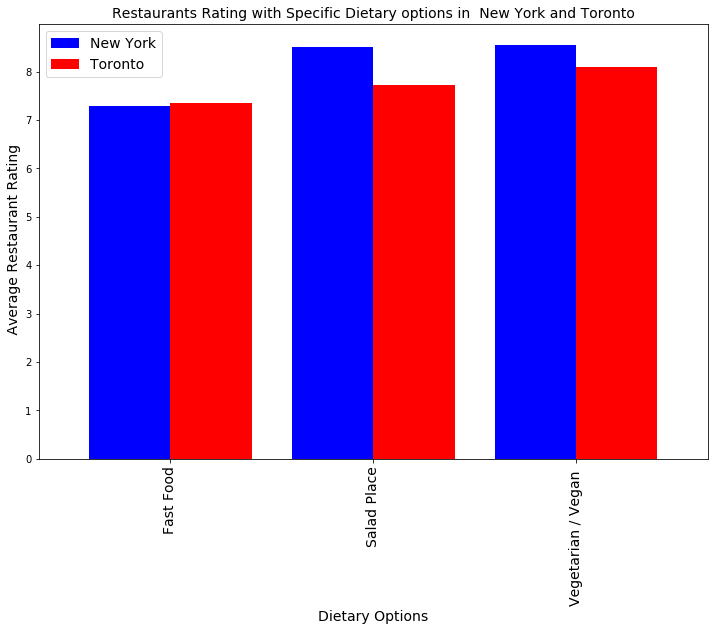

In [37]:
ax1=df2[['New York', 'Toronto']].plot(kind='bar', figsize=(12,8), width=0.8, color=['b','r'])
legend=ax1.legend(prop={'size':14})
ax1.set_title("Restaurants Rating with Specific Dietary options in  New York and Toronto", Fontsize=14)
ax1.set_xlabel("Dietary Options", Fontsize=14)
ax1.set_ylabel(" Average Restaurant Rating", Fontsize=14)
ax1.tick_params(axis='x',labelsize=14)
plt.show()

### Diversity Food Table

In [38]:
Diversity={'Cuisine Name':['Brazilian','Chinese', 'Colombian','Ethiopian','French','Greek','Indian','Italian','Japanese','Lebanese','Mexican','Persian','Turkish'],
         'New York':[len(NY_Brazilian),len(NY_Chinese),len(NY_Colombian),len(NY_Ethiopian),len(NY_French),len(NY_Greek),len(NY_Indian),\
                     len(NY_Italian),len(NY_Japanese),len(NY_Lebanese),len(NY_Mexican),len(NY_Persian),len(NY_Turkish)],
         'Toronto':[len(Toronto_Brazilian),len(Toronto_Chinese),len(Toronto_Colombian),len(Toronto_Ethiopian),\
                    len(Toronto_French),len(Toronto_Greek),len(Toronto_Indian),len(Toronto_Italian),len(Toronto_Japanese),\
                    len(NY_Lebanese),len(Toronto_Mexican),len(Toronto_Persian),len(Toronto_Turkish)]}

In [40]:
df3 = pd.DataFrame(Diversity) 
df3.set_index('Cuisine Name', inplace=True)
df3.head(13)

,New York,Toronto
Cuisine Name,,
Brazilian,2,1
Chinese,48,9
Colombian,0,1
Ethiopian,4,1
French,44,4
Greek,21,3
Indian,35,6
Italian,121,24
Japanese,43,17


/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/plotting/_core.py:185: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


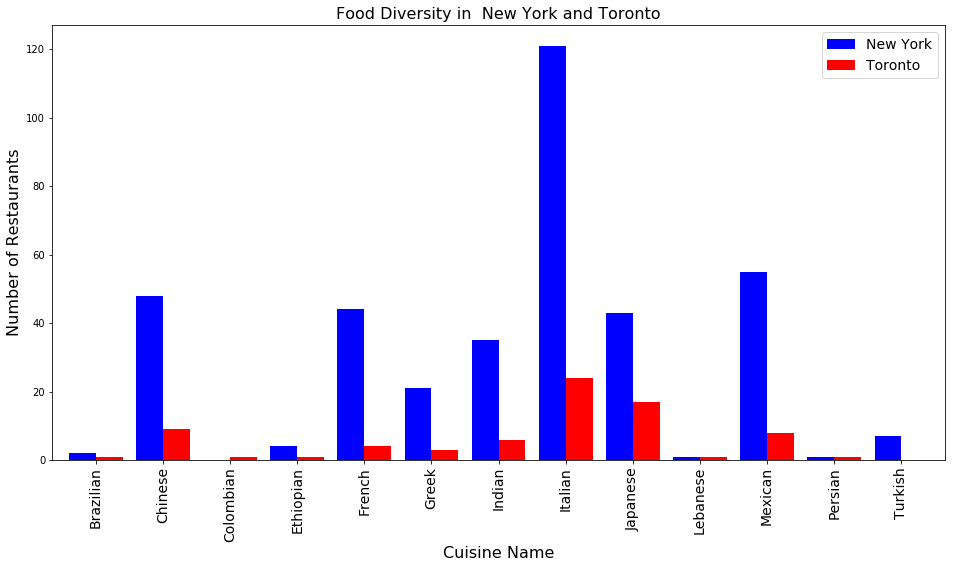

In [41]:
ax2=df3[['New York', 'Toronto']].plot(kind='bar', figsize=(16,8), width=0.8, colors=['b','r'])
legend=ax2.legend(prop={'size':14})
ax2.set_title("Food Diversity in  New York and Toronto", Fontsize=16)
ax2.set_xlabel("Cuisine Name", Fontsize=16)
ax2.set_ylabel("Number of Restaurants", Fontsize=16)
ax2.tick_params(axis='x',labelsize=14)
plt.show()

# Parks and Playgrounds

In [42]:
NY_Park=NY_venues[NY_venues['Venue Category']=='Park'].reset_index(drop=True)
Toronto_Park=Toronto_venues[Toronto_venues['Venue Category']=='Park'].reset_index(drop=True)

In [43]:
NY_Playground=NY_venues[NY_venues['Venue Category']=='Playground'].reset_index(drop=True)
Toronto_Playground=Toronto_venues[Toronto_venues['Venue Category']=='Playground'].reset_index(drop=True)

In [45]:
GreenSpace={'Space':['Park','Playground'],
         'New York':[len(NY_Park),len(NY_Playground)],
         'Toronto':[len(Toronto_Park),len(Toronto_Playground)]}

In [46]:
df4 = pd.DataFrame(GreenSpace) 
df4.set_index('Space', inplace=True)
df4.head(3)

,New York,Toronto
Space,,
Park,60,17
Playground,17,2


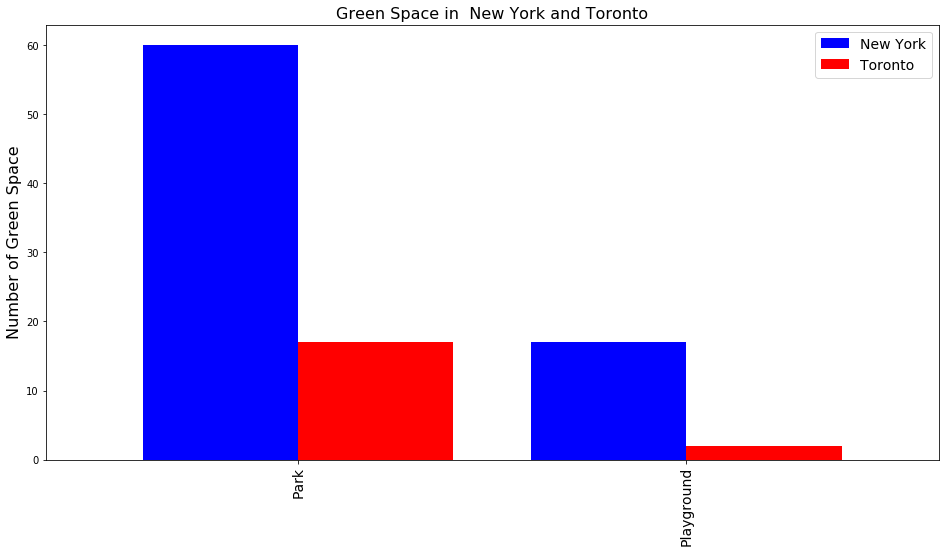

In [47]:
ax3=df4[['New York', 'Toronto']].plot(kind='bar', figsize=(16,8), width=0.8, colors=['b','r'])
legend=ax3.legend(prop={'size':14})
ax3.set_title("Green Space in  New York and Toronto", Fontsize=16)
ax3.set_xlabel("", Fontsize=16)
ax3.set_ylabel("Number of Green Space", Fontsize=16)
ax3.tick_params(axis='x',labelsize=14)
plt.show()

In [48]:
NY_Playground['Rating']=np.nan
Toronto_Playground['Rating']=np.nan

In [49]:
Ratings(NY_Playground)
Ratings(Toronto_Playground)

This venue has not been rated yet.
This venue has not been rated yet.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category,Rating
0,Rosedale,43.679563,-79.377529,Rosedale Park,4aff2d47f964a520743522e3,43.682328,-79.378934,Playground,NaN
1,"Cabbagetown,St. James Town",43.667967,-79.367675,Winchester Park,4bb606111344b71388da9c04,43.666231,-79.371631,Playground,6.6


In [54]:
RatingGreenSpace={'Space':['Playground'],
         'New York':[NY_Playground["Rating"].mean()],
         'Toronto':[Toronto_Playground["Rating"].mean()]}

In [56]:
df5 = pd.DataFrame(RatingGreenSpace) 
df5.set_index('Space', inplace=True)
df5.head()

,New York,Toronto
Space,,
Playground,8.20625,6.6


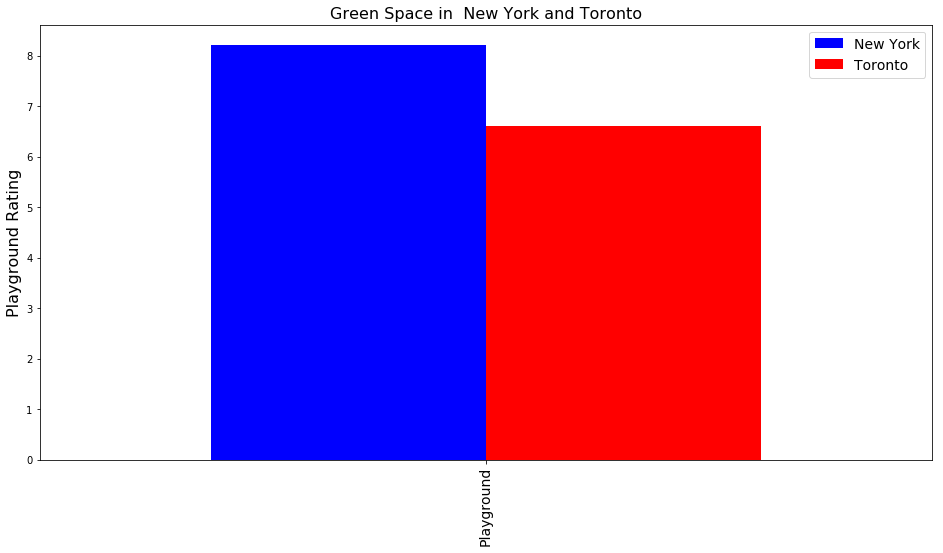

In [58]:
ax4=df5[['New York', 'Toronto']].plot(kind='bar', figsize=(16,8), width=0.8, colors=['b','r'])
legend=ax4.legend(prop={'size':14})
ax4.set_title("Green Space in  New York and Toronto", Fontsize=16)
ax4.set_xlabel("", Fontsize=16)
ax4.set_ylabel("Playground Rating", Fontsize=16)
ax4.tick_params(axis='x',labelsize=14)
plt.show()

# Exploring Neighbourhoods Most Common Venues

In [59]:
NY_onehot = pd.get_dummies(NY_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
NY_onehot['Neighborhood'] = NY_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [NY_onehot.columns[-1]] + list(NY_onehot.columns[:-1])
NY_onehot = NY_onehot[fixed_columns]

In [60]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Neighborhood'] = Toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

In [63]:
NY_grouped = NY_onehot.groupby('Neighborhood').mean().reset_index()
NY_grouped.shape

(40, 336)

In [64]:
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()
Toronto_grouped.shape

(18, 207)

In [65]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [66]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
NY_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
NY_neighborhoods_venues_sorted['Neighborhood'] = NY_grouped['Neighborhood']

for ind in np.arange(NY_grouped.shape[0]):
    NY_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(NY_grouped.iloc[ind, :], num_top_venues)

NY_neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Park,Coffee Shop,Gym,Memorial Site,Hotel,Wine Shop,Boat or Ferry,Women's Store,Pizza Place,Plaza
1,Carnegie Hill,Pizza Place,Coffee Shop,Café,Bookstore,Bar,Spa,Bakery,Cosmetics Shop,Grocery Store,Gym
2,Central Harlem,Bar,African Restaurant,American Restaurant,Cosmetics Shop,French Restaurant,Chinese Restaurant,Seafood Restaurant,Boutique,Gym,Beer Bar
3,Chelsea,Coffee Shop,Bakery,Ice Cream Shop,Italian Restaurant,Nightclub,Seafood Restaurant,American Restaurant,Theater,Hotel,Men's Store
4,Chinatown,Chinese Restaurant,Cocktail Bar,American Restaurant,Bakery,Vietnamese Restaurant,Spa,Bubble Tea Shop,Salon / Barbershop,Dumpling Restaurant,Sandwich Place


In [67]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Toronto_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
Toronto_neighborhoods_venues_sorted['Neighborhood'] = Toronto_grouped['Neighborhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    Toronto_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

Toronto_neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide,King,Richmond",Coffee Shop,Thai Restaurant,Bar,Steakhouse,Café,Burger Joint,Pizza Place,Asian Restaurant,Hotel,American Restaurant
1,Berczy Park,Coffee Shop,Steakhouse,Gourmet Shop,Hotel,Liquor Store,Bistro,Belgian Restaurant,Beer Bar,Shopping Mall,Beach
2,"CN Tower,Bathurst Quay,Island airport,Harbourf...",Airport Lounge,Airport Service,Harbor / Marina,Coffee Shop,Boat or Ferry,Bar,Boutique,Plane,Sculpture Garden,Airport Terminal
3,"Cabbagetown,St. James Town",Coffee Shop,Grocery Store,Bakery,Pet Store,Pizza Place,Restaurant,Pub,Café,Italian Restaurant,Park
4,Central Bay Street,Coffee Shop,Italian Restaurant,Fried Chicken Joint,Café,Sandwich Place,Ice Cream Shop,Burger Joint,Salad Place,Japanese Restaurant,Vegetarian / Vegan Restaurant


# Clustering Neighbourhoods

In [68]:
# set number of clusters
kclusters = 5

NY_grouped_clustering = NY_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(NY_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 
NY_neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Park,Coffee Shop,Gym,Memorial Site,Hotel,Wine Shop,Boat or Ferry,Women's Store,Pizza Place,Plaza
1,Carnegie Hill,Pizza Place,Coffee Shop,Café,Bookstore,Bar,Spa,Bakery,Cosmetics Shop,Grocery Store,Gym
2,Central Harlem,Bar,African Restaurant,American Restaurant,Cosmetics Shop,French Restaurant,Chinese Restaurant,Seafood Restaurant,Boutique,Gym,Beer Bar
3,Chelsea,Coffee Shop,Bakery,Ice Cream Shop,Italian Restaurant,Nightclub,Seafood Restaurant,American Restaurant,Theater,Hotel,Men's Store
4,Chinatown,Chinese Restaurant,Cocktail Bar,American Restaurant,Bakery,Vietnamese Restaurant,Spa,Bubble Tea Shop,Salon / Barbershop,Dumpling Restaurant,Sandwich Place


In [69]:
# add clustering labels
NY_neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

NY_merged = Downtown_NY

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
NY_merged = NY_merged.join(NY_neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

NY_merged.head(41) 

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,1,Sandwich Place,Coffee Shop,Yoga Studio,Bank,Supplement Shop,Steakhouse,Shopping Mall,Seafood Restaurant,Clothing Store,Pizza Place
1,Manhattan,Chinatown,40.715618,-73.994279,0,Chinese Restaurant,Cocktail Bar,American Restaurant,Bakery,Vietnamese Restaurant,Spa,Bubble Tea Shop,Salon / Barbershop,Dumpling Restaurant,Sandwich Place
2,Manhattan,Washington Heights,40.851903,-73.936900,3,Café,Mobile Phone Shop,Bakery,Grocery Store,Spanish Restaurant,Tapas Restaurant,Chinese Restaurant,New American Restaurant,Donut Shop,Mexican Restaurant
3,Manhattan,Inwood,40.867684,-73.921210,3,Mexican Restaurant,Café,Lounge,Pizza Place,Deli / Bodega,Chinese Restaurant,Park,Spanish Restaurant,Bakery,American Restaurant
4,Manhattan,Hamilton Heights,40.823604,-73.949688,3,Café,Mexican Restaurant,Pizza Place,Coffee Shop,Yoga Studio,Park,Caribbean Restaurant,Chinese Restaurant,Bakery,School
5,Manhattan,Manhattanville,40.816934,-73.957385,1,Coffee Shop,Chinese Restaurant,Deli / Bodega,Park,Italian Restaurant,Seafood Restaurant,Climbing Gym,Food & Drink Shop,Lounge,Bike Trail
6,Manhattan,Central Harlem,40.815976,-73.943211,1,Bar,African Restaurant,American Restaurant,Cosmetics Shop,French Restaurant,Chinese Restaurant,Seafood Restaurant,Boutique,Gym,Beer Bar
7,Manhattan,East Harlem,40.792249,-73.944182,3,Mexican Restaurant,Deli / Bodega,Bakery,Thai Restaurant,Latin American Restaurant,Convenience Store,Seafood Restaurant,Gas Station,Taco Place,French Restaurant
8,Manhattan,Upper East Side,40.775639,-73.960508,2,Italian Restaurant,Exhibit,Art Gallery,Bakery,Coffee Shop,Juice Bar,Hotel,Gym / Fitness Center,French Restaurant,Boutique
9,Manhattan,Yorkville,40.775930,-73.947118,1,Coffee Shop,Bar,Italian Restaurant,Gym,Pizza Place,Deli / Bodega,Sushi Restaurant,Wine Shop,Japanese Restaurant,Diner


In [70]:
# set number of clusters
kclusters = 5

Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 
Toronto_neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide,King,Richmond",Coffee Shop,Thai Restaurant,Bar,Steakhouse,Café,Burger Joint,Pizza Place,Asian Restaurant,Hotel,American Restaurant
1,Berczy Park,Coffee Shop,Steakhouse,Gourmet Shop,Hotel,Liquor Store,Bistro,Belgian Restaurant,Beer Bar,Shopping Mall,Beach
2,"CN Tower,Bathurst Quay,Island airport,Harbourf...",Airport Lounge,Airport Service,Harbor / Marina,Coffee Shop,Boat or Ferry,Bar,Boutique,Plane,Sculpture Garden,Airport Terminal
3,"Cabbagetown,St. James Town",Coffee Shop,Grocery Store,Bakery,Pet Store,Pizza Place,Restaurant,Pub,Café,Italian Restaurant,Park
4,Central Bay Street,Coffee Shop,Italian Restaurant,Fried Chicken Joint,Café,Sandwich Place,Ice Cream Shop,Burger Joint,Salad Place,Japanese Restaurant,Vegetarian / Vegan Restaurant


In [71]:
# add clustering labels

Toronto_neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Toronto_merged = Downtown_Toronto

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Toronto_merged = Toronto_merged.join(Toronto_neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Toronto_merged.head(100) 

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,Rosedale,43.679563,-79.377529,4,Park,Building,Playground,Trail,Electronics Store,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Discount Store
1,Downtown Toronto,"Cabbagetown,St. James Town",43.667967,-79.367675,0,Coffee Shop,Grocery Store,Bakery,Pet Store,Pizza Place,Restaurant,Pub,Café,Italian Restaurant,Park
2,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,0,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Gay Bar,Restaurant,Café,Hotel,Mediterranean Restaurant,Men's Store,Gym
3,Downtown Toronto,"Harbourfront,Regent Park",43.654260,-79.360636,0,Coffee Shop,Park,Bakery,Café,Breakfast Spot,Restaurant,Pub,Theater,Mexican Restaurant,Dessert Shop
4,Downtown Toronto,"Ryerson,Garden District",43.657162,-79.378937,0,Coffee Shop,Clothing Store,Cosmetics Shop,Fast Food Restaurant,Café,Hotel,Bakery,Ramen Restaurant,Pizza Place,Bookstore
5,Downtown Toronto,St. James Town,43.651494,-79.375418,0,Coffee Shop,Café,Restaurant,Italian Restaurant,Hotel,Breakfast Spot,Bakery,Cocktail Bar,Gastropub,Seafood Restaurant
6,Downtown Toronto,Berczy Park,43.644771,-79.373306,0,Coffee Shop,Steakhouse,Gourmet Shop,Hotel,Liquor Store,Bistro,Belgian Restaurant,Beer Bar,Shopping Mall,Beach
7,Downtown Toronto,Central Bay Street,43.657952,-79.387383,0,Coffee Shop,Italian Restaurant,Fried Chicken Joint,Café,Sandwich Place,Ice Cream Shop,Burger Joint,Salad Place,Japanese Restaurant,Vegetarian / Vegan Restaurant
8,Downtown Toronto,"Adelaide,King,Richmond",43.650571,-79.384568,0,Coffee Shop,Thai Restaurant,Bar,Steakhouse,Café,Burger Joint,Pizza Place,Asian Restaurant,Hotel,American Restaurant
9,Downtown Toronto,"Harbourfront East,Toronto Islands,Union Station",43.640816,-79.381752,0,Coffee Shop,Aquarium,Café,Hotel,Brewery,Fried Chicken Joint,Italian Restaurant,Scenic Lookout,Sporting Goods Shop,Sports Bar


In [73]:
NY_Cluster0=NY_merged[NY_merged['Cluster Labels']==0].reset_index(drop=True)
NY_Cluster1=NY_merged[NY_merged['Cluster Labels']==1].reset_index(drop=True)
NY_Cluster2=NY_merged[NY_merged['Cluster Labels']==2].reset_index(drop=True)
NY_Cluster3=NY_merged[NY_merged['Cluster Labels']==3].reset_index(drop=True)
NY_Cluster4=NY_merged[NY_merged['Cluster Labels']==4].reset_index(drop=True)

In [74]:
NY_Cluster0['1st Most Common Venue'].value_counts()

Bar                   1
Chinese Restaurant    1
Name: 1st Most Common Venue, dtype: int64

In [75]:
NY_Cluster1['1st Most Common Venue'].value_counts()

Coffee Shop             4
Gym / Fitness Center    3
Bar                     2
Italian Restaurant      2
Hotel                   2
Sandwich Place          2
Park                    2
Café                    1
Indian Restaurant       1
Pizza Place             1
Theater                 1
American Restaurant     1
Korean Restaurant       1
Name: 1st Most Common Venue, dtype: int64

In [76]:
NY_Cluster2['1st Most Common Venue'].value_counts()

Italian Restaurant    6
Coffee Shop           1
Theater               1
Boutique              1
Name: 1st Most Common Venue, dtype: int64

In [77]:
NY_Cluster3['1st Most Common Venue'].value_counts()

Mexican Restaurant    3
Café                  2
Name: 1st Most Common Venue, dtype: int64

In [78]:
NY_Cluster4['1st Most Common Venue'].value_counts()

Park    1
Name: 1st Most Common Venue, dtype: int64

In [81]:
Toronto_Cluster0=Toronto_merged[Toronto_merged['Cluster Labels']==0].reset_index(drop=True)
Toronto_Cluster1=Toronto_merged[Toronto_merged['Cluster Labels']==1].reset_index(drop=True)
Toronto_Cluster2=Toronto_merged[Toronto_merged['Cluster Labels']==2].reset_index(drop=True)
Toronto_Cluster3=Toronto_merged[Toronto_merged['Cluster Labels']==3].reset_index(drop=True)
Toronto_Cluster4=Toronto_merged[Toronto_merged['Cluster Labels']==4].reset_index(drop=True)

In [82]:
Toronto_Cluster0['1st Most Common Venue'].value_counts()

Coffee Shop       11
Café               2
Airport Lounge     1
Name: 1st Most Common Venue, dtype: int64

In [83]:
Toronto_Cluster1['1st Most Common Venue'].value_counts()

Coffee Shop    1
Name: 1st Most Common Venue, dtype: int64

In [84]:
Toronto_Cluster2['1st Most Common Venue'].value_counts()

Gym    1
Name: 1st Most Common Venue, dtype: int64

In [85]:
Toronto_Cluster3['1st Most Common Venue'].value_counts()

Grocery Store    1
Name: 1st Most Common Venue, dtype: int64

In [86]:
Toronto_Cluster4['1st Most Common Venue'].value_counts()

Park    1
Name: 1st Most Common Venue, dtype: int64

# Visualization of Clusters

In [87]:
# Downtown New York Coordinates
latitude=40.7831
longitude=-73.9712
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(NY_merged['Latitude'], NY_merged['Longitude'], NY_merged['Neighborhood'], NY_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [91]:
# Downtown Toronto Coordinates

latitude=43.6532
longitude=-79.3832
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighborhood'], Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters